<a href="https://colab.research.google.com/github/SangsooYoo/DHistory/blob/master/study/ML/3rd_live_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Error: IPyKernel not installed into interpreter Python 2.7.16 64-bit:/usr/bin/python

In [2]:
!nvidia-smi

Fri Jun 25 10:18:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [48]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

Transfer Learning을 통한 Cats and Dogs 데이터셋 분류 성능 개선

Step 1. input tensor와 target tensor준비

(1) Cats and Dogs 데이터셋 다운로드

In [6]:
url ='https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

In [11]:
keras.utils.get_file(fname='cats_and_dogs_filtered.zip', 
                     origin=url, 
                     extract=True, 
                     cache_dir='/content')

'/content/datasets/cats_and_dogs_filtered.zip'

(2) ImageDataGenerator를 이용해 이미지 파일을 load하기위한 경로 지정

In [12]:
train_dir = '/content/datasets/cats_and_dogs_filtered/train'
validation_dir = '/content/datasets/cats_and_dogs_filtered/validation'

(3) ImageDataGenerator객체 생성

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(rescale=1./255.)
validation_gen = ImageDataGenerator(rescale=1./255.) 

.flow_from_directory()메서드를 이용하여 학습데이터와 검증데이터를 위한 DirectoryIterator객체 생성

In [17]:
train_generator = train_gen.flow_from_directory(directory=train_dir, 
                              target_size = (224,224),
                              batch_size=32,
                              shuffle=True,
                              class_mode='binary')

Found 2000 images belonging to 2 classes.


In [22]:
x, y = next(train_generator)
x.shape

(32, 224, 224, 3)

In [23]:
y.shape

(32,)

In [24]:
y

array([0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.],
      dtype=float32)

In [25]:
validation_generator = train_gen.flow_from_directory(directory=validation_dir, 
                              target_size = (224,224),
                              batch_size=32,
                              class_mode='binary')

Found 1000 images belonging to 2 classes.


Step 2. VGG16을 Backbone으로 하는 모델 디자인 및 학습정보 설정
(1)Pre-trained된 VGG16모델 객체 생성


*   imagenet 데이터를 이용해 학습된 모델 객체생성
*   classification layer 제외



In [28]:
from tensorflow.keras.applications import VGG16

In [35]:
conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [36]:
model = keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(units=1, activation='sigmoid'))

In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 21,137,729
Non-trainable params: 0
_________________________________________________________________


(3) VGG16 Backbone 모델의 가중치 동결(학습대상 가중치에서 제외)


In [38]:
conv_base.trainable = False

In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [41]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

step3. 모델에 데이터 제너레이터 연결 후 학습
model.fit() 이용하여 데이터 연결 및 학습시키기 
학습 과정은 history 변수에 저장됨

In [43]:
history = model.fit( train_generator, 
                    epochs=30, 
                    steps_per_epoch=len(train_generator), 
                    validation_data=validation_generator, 
                    validation_steps=len(validation_generator) )

Epoch 1/30
63/63 [==============================] - 25s 401ms/step - loss: 0.2890 - accuracy: 0.8910 - val_loss: 0.2718 - val_accuracy: 0.8930
Epoch 2/30
63/63 [==============================] - 22s 348ms/step - loss: 0.2178 - accuracy: 0.9250 - val_loss: 0.2475 - val_accuracy: 0.9050
Epoch 3/30
63/63 [==============================] - 22s 350ms/step - loss: 0.1709 - accuracy: 0.9440 - val_loss: 0.2448 - val_accuracy: 0.8980
Epoch 4/30
63/63 [==============================] - 22s 350ms/step - loss: 0.1439 - accuracy: 0.9555 - val_loss: 0.2195 - val_accuracy: 0.9140
Epoch 5/30
63/63 [==============================] - 22s 352ms/step - loss: 0.1203 - accuracy: 0.9655 - val_loss: 0.2150 - val_accuracy: 0.9120
Epoch 6/30
63/63 [==============================] - 22s 350ms/step - loss: 0.0998 - accuracy: 0.9730 - val_loss: 0.2280 - val_accuracy: 0.9060
Epoch 7/30
63/63 [==============================] - 22s 352ms/step - loss: 0.0881 - accuracy: 0.9790 - val_loss: 0.2118 - val_accuracy: 0.9160

In [46]:
def history_chart(history): 
  acc = history.history['accuracy'] 
  val_acc = history.history['val_accuracy'] 
  loss = history.history['loss'] 
  val_loss = history.history['val_loss'] 
  epochs = range(len(acc)) 
  plt.plot(epochs, acc, 'bo', label='Training acc') 
  plt.plot(epochs, val_acc, 'b', label='Validation acc') 
  plt.title('Training and validation accuracy') 
  plt.legend() 
  plt.figure() 
  plt.plot(epochs, loss, 'bo', label='Training loss') 
  plt.plot(epochs, val_loss, 'b', label='Validation loss') 
  plt.title('Training and validation loss') 
  plt.legend() 
  plt.show()

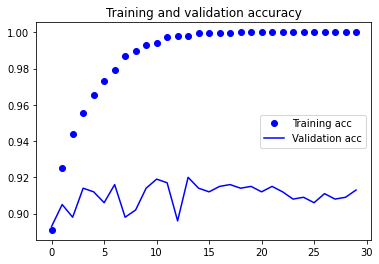

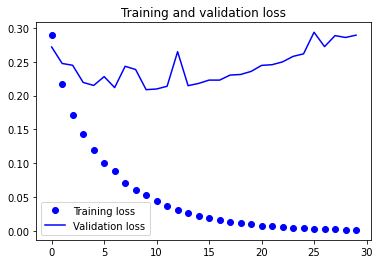

In [49]:
history_chart(history)